# Motor Testing April 6th

On April 6th 2025, we took Brightside out for driving/testing for the first time since FSGP 2024.

Due to the rain, tests were conducted in the undercover parking lot nearest to EDC. While we spent most of the testing time debugging, we were able to conduct a small number of test drives.

See https://docs.google.com/document/d/1Rx3J4bNzHDbjxchzbmqbx4wmzVHT7njctfJhgrXQq_g/edit for complete details.

## Cruising Test

We conducted a very brief cruising test at 2:59PM in which we got Chris to floor the accelerator, then release it and finally brake when necessary (the parking lot is not very long).

This test was conducted under our [Cruising Test Plan](https://docs.google.com/document/d/1nRl-FxTlJjzzBGooMMIHlvJZYS2zg53nI7BmjzIfTFw/edit?tab=t.0#heading=h.x81rs6u2klim). See all STG's plans [here](https://drive.google.com/drive/u/1/folders/1l5ZTJP1LZwLBvmLuFI7MEXHikJNSyDR0).

Video: https://drive.google.com/file/d/1kIt3Dud8n91xUy1W2zfV0xKJm5OHyfYW/view?usp=drive_link


### 1. Query Data From Influx

Thanks to Aarjav for quickly uploading the Memorator data to InfluxDB on the elec bay computer.

In [8]:
from data_tools import query
from data_tools.collections import TimeSeries
from datetime import datetime, date, time, timezone
import numpy as np
import matplotlib.pyplot as plt
import dill
import os

load_from_file = True

utc_offset_h = 7
cruising_test_start_utc = time(14 + utc_offset_h, 57, 40)
cruising_test_stop_utc = time(14 + utc_offset_h, 57, 58)
test_date = date(2025, 4, 6)  # April 6th, 2025
start_time = datetime.combine(test_date, cruising_test_start_utc, tzinfo=timezone.utc)
stop_time = datetime.combine(test_date, cruising_test_stop_utc, tzinfo=timezone.utc)

if load_from_file:
    out_dir = os.path.join("..", "data", "cruising_test_2025-04-06")
    speed_file = os.path.join(out_dir, "speed_kph.bin")
    accel_file = os.path.join(out_dir, "accelator_percent.bin")
    brake_file = os.path.join(out_dir, "brake_pressed.bin")
    with open(speed_file, 'rb') as f:
        speed_kph = dill.load(f)
    with open(accel_file, 'rb') as f:
        accelator_percent = dill.load(f)
    with open(brake_file, 'rb') as f:
        brake_pressed = dill.load(f)
else:
    client = query.DBClient()
    
    # get data for 1 minute timestamps
    speed_kph: TimeSeries = client.query_time_series(start_time, stop_time, "MotorRotatingSpeed")
    accelator_percent: TimeSeries = client.query_time_series(start_time, stop_time, "AcceleratorPosition")
    brake_pressed: TimeSeries = client.query_time_series(start_time, stop_time, "BrakePressed")

### 2. Plot The Data

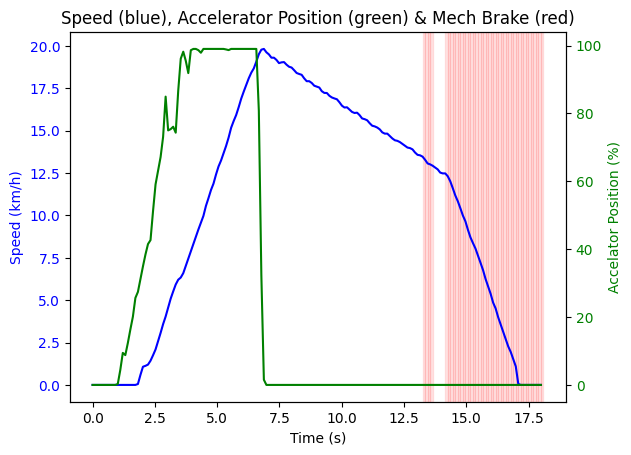

In [9]:
fig, ax1 = plt.subplots()

t_axis = speed_kph.x_axis
period = speed_kph.granularity

# Plot Speed (km/h) on the left y-axis
ax1.plot(t_axis, speed_kph, color='blue')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Speed (km/h)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for Accelerator Position (%)
ax2 = ax1.twinx()
ax2.plot(t_axis, accelator_percent, color='green')
ax2.set_ylabel('Accelator Position (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Change background color based on brake_pressed (1 or 0)
for i, value in enumerate(brake_pressed):
    if value == 1:
        ax1.axvspan(t_axis[i], t_axis[i]+period, color='red', alpha=0.1)  # Highlight background when brake is pressed

plt.title("Speed (blue), Accelerator Position (green) & Mech Brake (red)")

plt.show()

From the data above, we can see all the key features that are important to our cruising test:
1. high acceleration at the start so that we can get up to speed without travelling too far
2. full release of the accelerator for the remainder of the test
3. mechanical brake applied to bring the car safely to a stop

The key period of time is between when we release the accelerator and first apply the mechanical brake. This is our cruising period.

### 3. Save The Data

In case Influx is not available, the TimeSeries objects can be loaded from disk using ``dill``.

In [10]:
import os
import dill

out_dir = os.path.join("..", "data", "cruising_test_2025-04-06")
speed_file = os.path.join(out_dir, "speed_kph.bin")
accel_file = os.path.join(out_dir, "accelator_percent.bin")
brake_file = os.path.join(out_dir, "brake_pressed.bin")

os.makedirs(out_dir, exist_ok=True) 

for filepath, data in zip((speed_file, accel_file, brake_file),
                          (speed_kph, accelator_percent, brake_pressed)):
    with open(filepath, 'wb') as f:
        dill.dump(data, f)

### 4. And Now... Analyze!

Text(0.5, 0, 'Time (s)')

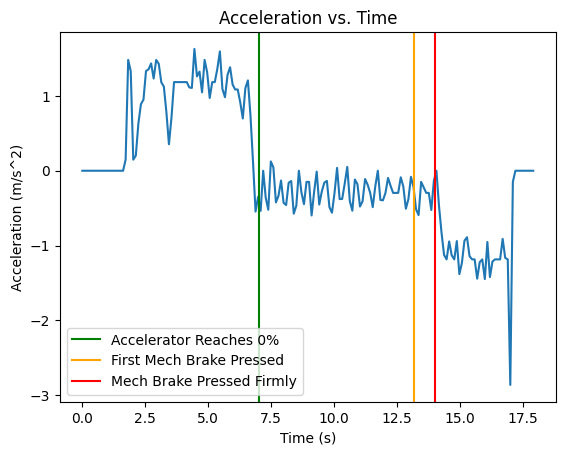

In [11]:
import numpy as np

# (kmh1 - kmh0) / period --> kmh/s
kmh_per_mps = 3.6
# acceleration is signed, meters per second squared
acceleration = (np.diff(speed_kph) / period) / kmh_per_mps
plt.plot(t_axis[:-1], acceleration)  # np.diff results in a 1 item shorter array

# label some events
t_accelerator_on_delay = 3  # roughly, seconds until the accelerator is pressed
t_accelerator_off = (np.array(accelator_percent)[int(t_accelerator_on_delay/period):]==0).argmax(axis=0) * period + t_accelerator_on_delay
t_first_brake = (np.array(brake_pressed)!=0).argmax(axis=0) * period
t_before_major_brake = 13.5  # seconds after start, time between first brake and major braking
t_major_braking = (np.array(brake_pressed)[int(t_before_major_brake/period):]!=0).argmax(axis=0) * period + t_before_major_brake

plt.axvline(t_accelerator_off, c="green", label="Accelerator Reaches 0%")
plt.axvline(t_first_brake, c="orange", label="First Mech Brake Pressed")
plt.axvline(14, c="red", label="Mech Brake Pressed Firmly")

plt.legend()

plt.title("Acceleration vs. Time")
plt.ylabel("Acceleration (m/s^2)")
plt.xlabel("Time (s)")

Next, we calculate acceleration as the derivative of speed over time. I have highlighted key timestamps in vertical bars. First, the acceleration is very positive as we are flooring the accelerator. Then, we release the accelerator, and we slowly decelerate due to mechanical losses (primarily rolling resistance I think). Finally, we see a strong deceleration due to the mechanical brake.

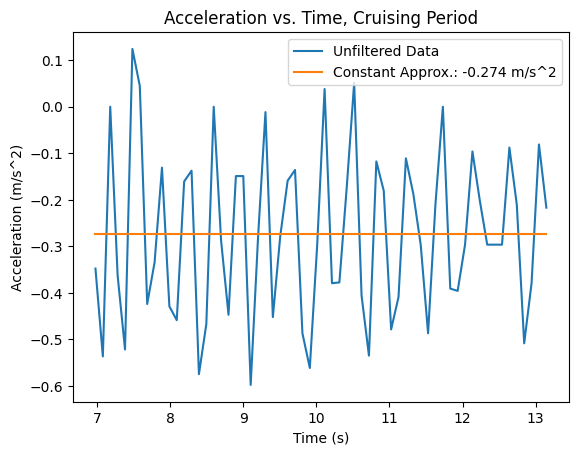

In [12]:
cruising_slice_i = int(t_accelerator_off / period)
cruising_slice_f = int(t_first_brake / period)

cruising_acceleration = acceleration[cruising_slice_i:cruising_slice_f]
cruising_t_axis = t_axis[cruising_slice_i:cruising_slice_f]

mean_cruising_acceleration = np.mean(cruising_acceleration)
contant_approx = np.ones(cruising_slice_f - cruising_slice_i) * mean_cruising_acceleration

plt.plot(cruising_t_axis, cruising_acceleration, label="Unfiltered Data")
plt.plot(cruising_t_axis, contant_approx, label=f"Constant Approx.: {mean_cruising_acceleration:.3} m/s^2")
plt.title("Acceleration vs. Time, Cruising Period")
plt.ylabel("Acceleration (m/s^2)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

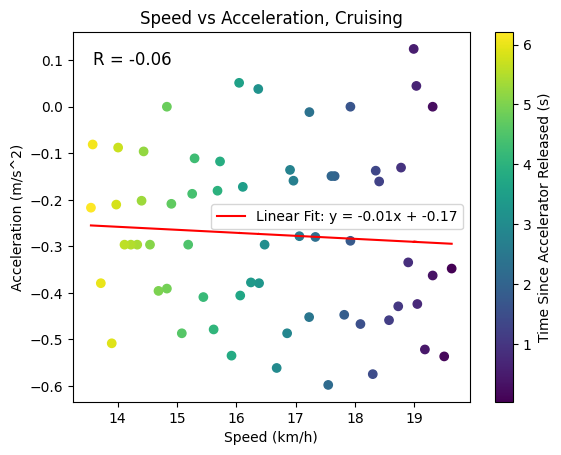

In [13]:
from scipy import stats

cruising_speed = speed_kph[cruising_slice_i:cruising_slice_f]

time_since_cruising = cruising_t_axis - cruising_slice_i * period

slope, intercept, r_value, p_value, std_err = stats.linregress(cruising_speed, cruising_acceleration)

fit_line = slope * cruising_speed + intercept

plt.scatter(cruising_speed, cruising_acceleration, c=time_since_cruising)
plt.title("Speed vs Acceleration, Cruising")
plt.xlabel("Speed (km/h)")
plt.ylabel("Acceleration (m/s^2)")
plt.colorbar(label="Time Since Accelerator Released (s)")

plt.text(0.05, 0.95, f"R = {r_value:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.plot(cruising_speed, fit_line, color='red', label=f"Linear Fit: y = {slope:.2f}x + {intercept:.2f}")
plt.legend()
plt.show()

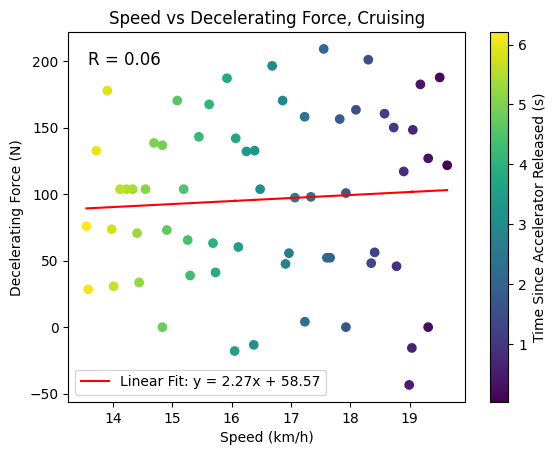

In [14]:
brightside_kgs = 350  # with 80kg driver. maybe ask chris for a more accurate value? we didn't use ballast for the test

# F = ma, and flip sign to get slowing force
cruising_slowing_force = cruising_acceleration * brightside_kgs * -1

slope, intercept, r_value, _, _ = stats.linregress(cruising_speed, cruising_slowing_force)

fit_line = slope * cruising_speed + intercept

plt.scatter(cruising_speed, cruising_slowing_force, c=time_since_cruising)
plt.title("Speed vs Decelerating Force, Cruising")
plt.xlabel("Speed (km/h)")
plt.ylabel("Decelerating Force (N)")
plt.colorbar(label="Time Since Accelerator Released (s)")

plt.text(0.05, 0.95, f"R = {r_value:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.plot(cruising_speed, fit_line, color='red', label=f"Linear Fit: y = {slope:.2f}x + {intercept:.2f}")
plt.legend()
plt.show()  

### IMU Data

Let's try the plot again with the baseline-subtracted IMU Z data. Note: IMU Z is the forward direction of the car. See ``imu_dat_april_6.ipynb`` for full details.

In [15]:
client = query.DBClient()

imu_z: TimeSeries = client.query_time_series(start_time, stop_time, "Acceleration_Z")

# period of time where car is not moving
static_start_time = datetime.combine(test_date, cruising_test_start_utc, tzinfo=timezone.utc)
static_stop_time = datetime.combine(test_date, cruising_test_stop_utc, tzinfo=timezone.utc)

imu_z_static: TimeSeries = client.query_time_series(static_start_time, static_stop_time, "Acceleration_Z")
z_static_accel = np.mean(imu_z_static)
zeroed_imu_z = imu_z - z_static_accel

cruising_test_start_utc = time(14 + utc_offset_h, 56)
cruising_test_stop_utc = time(14 + utc_offset_h, 57)

G = 9.81

imu_cruising_acceleration = zeroed_imu_z[cruising_slice_i:cruising_slice_f]/1000*G

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


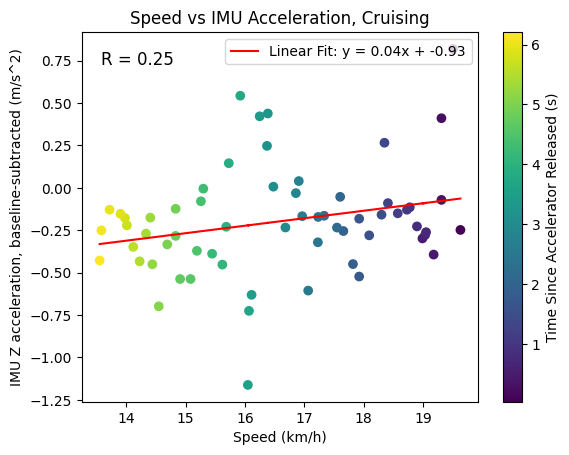

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(cruising_speed, imu_cruising_acceleration)

fit_line = slope * cruising_speed + intercept

plt.scatter(cruising_speed, imu_cruising_acceleration, c=time_since_cruising)
plt.title("Speed vs IMU Acceleration, Cruising")
plt.xlabel("Speed (km/h)")
plt.ylabel("IMU Z acceleration, baseline-subtracted (m/s^2)")
plt.colorbar(label="Time Since Accelerator Released (s)")

plt.text(0.05, 0.95, f"R = {r_value:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.plot(cruising_speed, fit_line, color='red', label=f"Linear Fit: y = {slope:.2f}x + {intercept:.2f}")
plt.legend()
plt.show()